In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

import sys
from pathlib import Path

MY_SRC = '../src/'
if MY_SRC not in sys.path:
    sys.path.append(MY_SRC)

import text_model
import data
import importlib

import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
from sklearn import metrics
import seaborn as sns

In [94]:
REPORTS_DIR = Path('../reports/')

CLASSES = ['creature', 'spell', 'enchantment', 'artifact']
prediction_cols = ['class_{}_p'.format(i) for i in range(4)]

def report_path(model_genre, test_genre, model_size):
    name = '{}-{}-model-{}-data-report.csv'.format(model_genre, model_size, test_genre)
    return REPORTS_DIR / name

def load_report(path):
    report = pd.read_csv(path,
                         dtype={'label': np.int32,
                                'prediction': np.int32,
                                **{c: np.float32 for c in prediction_cols}})
    return report

def report_metrics(r):
    probs = r[prediction_cols].values.astype(np.float32)
    predictions = np.argmax(probs, axis=-1)
    labels = r['label'].values
    m = {}
    m['accuracy'] = metrics.accuracy_score(labels, predictions)
    m['log_loss'] = metrics.log_loss(labels, probs)
    m['f1'] = metrics.f1_score(labels,
                               predictions,
                               average='macro')
    m['confusion'] = metrics.confusion_matrix(labels, predictions)
    return m

def print_metrics(m):
    print('Log loss: {:.4f}'.format(m['log_loss']))
    print('Accuracy: {:.4f}'.format(m['accuracy']))
    print('Macro F1: {:.4f}'.format(m['f1']))
    
    fig = plt.figure(figsize=(12, 12))
    sns.heatmap(m['confusion'], cmap='BuPu', xticklabels=CLASSES, yticklabels=CLASSES)

In [102]:
genres = ['all', 'legacy', 'modern']
best_size = 'small'

def genre_pair_metrics(mg, tg):
    return report_metrics(load_report(report_path(mg, tg, best_size)))

accuracy = pd.DataFrame.from_records([{**{tg: genre_pair_metrics(mg, tg)['accuracy']
                                          for tg in genres},
                                       'training': mg}
                                      for mg in genres],
                                     index='training')

In [103]:
accuracy

               all    legacy    modern
training                              
all       0.805682  0.800626  0.811721
legacy    0.764205  0.770355  0.750623
modern    0.759659  0.741127  0.783042

In [125]:
r = load_report(report_path('modern', 'modern', 'large'))

Log loss: 0.6132
Accuracy: 0.7855
Macro F1: 0.6103


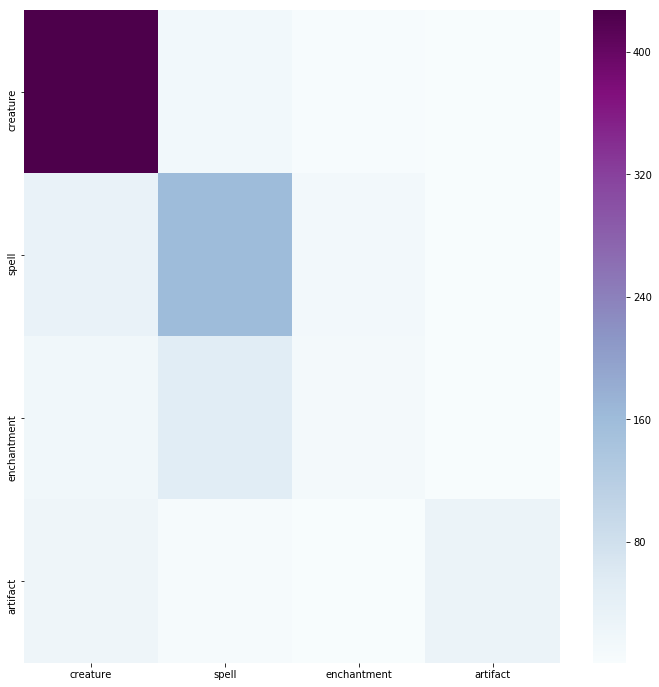

In [126]:
print_metrics(report_metrics(r))

In [127]:
s = load_report(report_path('modern', 'modern', 'small'))

Log loss: 0.5815
Accuracy: 0.7830
Macro F1: 0.6429


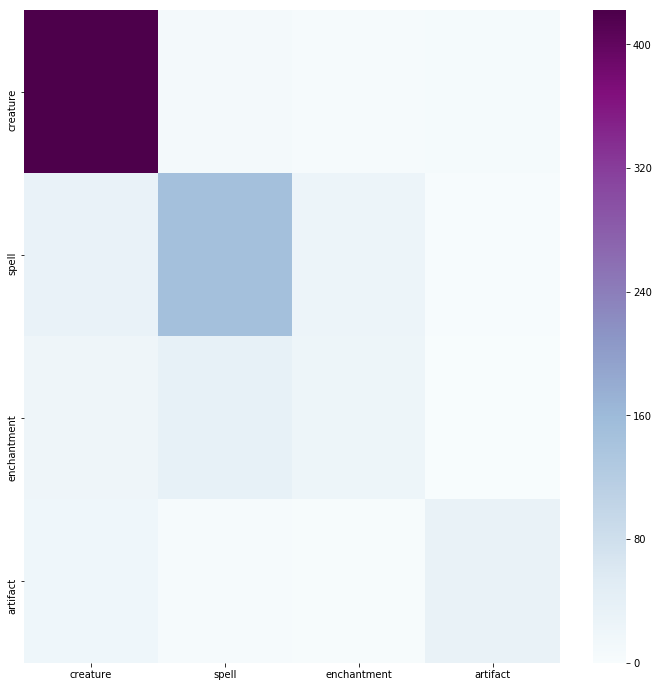

In [128]:
print_metrics(report_metrics(s))

In [ ]:
def intern(string):
    r = np.ndarray([len(string)], dtype=np.int64)
    for i, c in enumerate(string):
        r[i] = ord(c)
    return np.expand_dims(r, 0)

In [71]:
sess = tf.Session()
testing_data = data.preload_dataset('../data/tfrecord/all_testing_data.tfrecord',
                                    sess,
                                    features=features)

In [2]:
config_dir = '../experiments'
if config_dir not in sys.path:
    sys.path.append(config_dir)

import small_model_config
features = small_model_config.features
config = small_model_config.config

In [13]:
import self_attention
importlib.reload(self_attention)
importlib.reload(text_model)
model = text_model.Model(config,
                         checkpoint_path='checkpoints/all-small-model')
tokens = tf.placeholder(shape=[None, None], dtype=tf.int64, name='tokens')
predictions, attention_weights = model(tokens, return_attention_weights=True)

In [90]:
def attention_graph(name):
    in_tokens = intern(name)
    predictions, attention_weights = model.predict(in_tokens)
    fig = plt.figure(figsize=(5, 1))
    sns.heatmap(attention_weights[0], cmap='BuPu', xticklabels=name, cbar=False)
    return fig

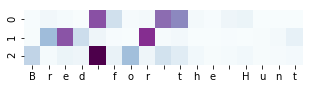

In [91]:
name = data._unintern_tokens(testing_data[0]['tokens'][22])
f = attention_graph(name)

In [79]:
f.savefig('tahngarth-attention.png')

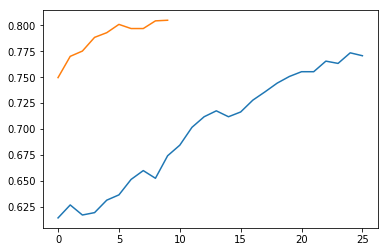

In [111]:
wv_acc_history = [.7496,
                  .7701,
                  .7752,
                  .7884,
                  .7929,
                  .8009,
                  .7969,
                  .7969,
                  .8043,
                  .8049]

char_acc_history = [.6144,
                    .6269,
                    .6172,
                    .6195,
                    .6315,
                    .6366,
                    .6515,
                    .6600,
                    .6526,
                    .6743,
                    .6845,
                    .7017,
                    .7119,
                    .7176,
                    .7119,
                    .7165,
                    .7279,
                    .7359,
                    .7443,
                    .7507,
                    .7553,
                    .7553,
                    .7655,
                    .7633,
                    .7735,
                    .7707]

plt.plot(char_acc_history)
plt.plot(wv_acc_history)
plt.show()